In [86]:
import os
import time
import copy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.io import imread

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
print('Notebook run using tf.keras:', tf.keras.__version__)
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Notebook run using tf.keras: 3.11.3


In [87]:
model = InceptionV3(weights='imagenet', include_top=True)
img = image.load_img("data/pop_cat.png", target_size=(299,299))
Xi = image.img_to_array(img)
Xi = np.expand_dims(Xi, axis=0)
Xi = preprocess_input(Xi)

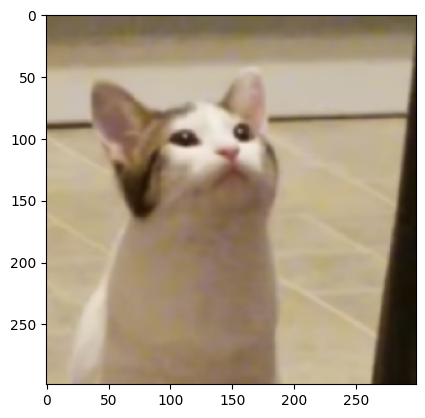

In [88]:
plt.imshow((Xi[0]/2 + 0.5))

In [89]:
yhat = model.predict(Xi)

label = decode_predictions(yhat, top=5)

for i in decode_predictions(yhat)[0]:
    print('%s (%.2f%%)' % (i[1], i[2]*100))

top_pred_classes = yhat[0].argsort()[-5:][::1]

print(top_pred_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Egyptian_cat (45.00%)
Siamese_cat (31.31%)
tabby (1.25%)
Angora (1.22%)
window_screen (0.93%)
[904 332 281 284 285]


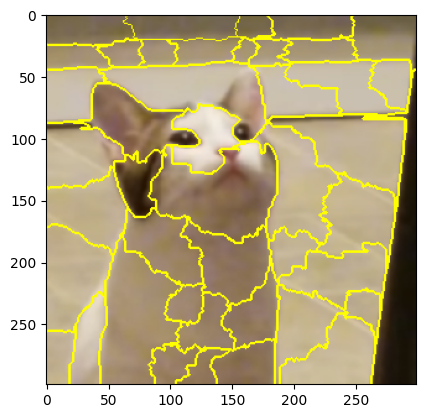

In [90]:
import skimage.segmentation
superpixels = skimage.segmentation.quickshift(Xi[0].astype('double'), kernel_size=5, max_dist=100, ratio=0.2)
plt.imshow(skimage.segmentation.mark_boundaries(Xi[0]/2+0.5, superpixels))


In [91]:
num_superpixels = np.unique(superpixels).shape[0]
print(num_superpixels)

44


In [92]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
print(perturbations.shape)
perturbations[0]

(150, 44)


array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0])

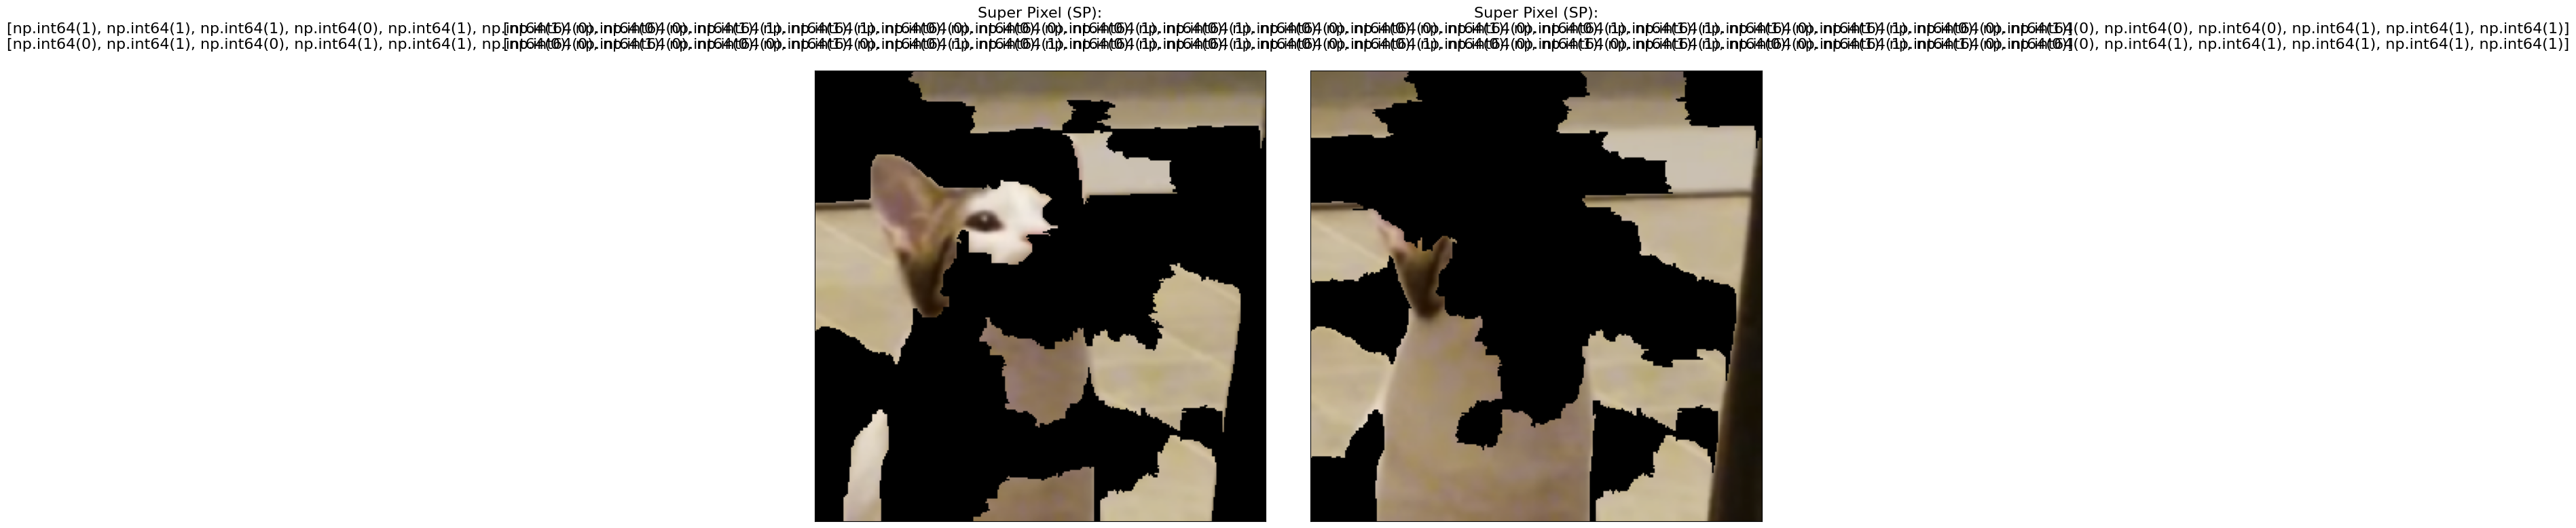

In [93]:
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

fig, ax = plt.subplots(1, 2, figsize=(18, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(2):
    ax[i].imshow(perturb_image(Xi[0]/2+0.5, perturbations[i], superpixels))
    ax[i].set_title('Super Pixel (SP):\n'+
                    str([i for i in perturbations[i][:22]])+'\n'+
                    str([i for i in perturbations[i][22:]])+'\n', fontsize=16)

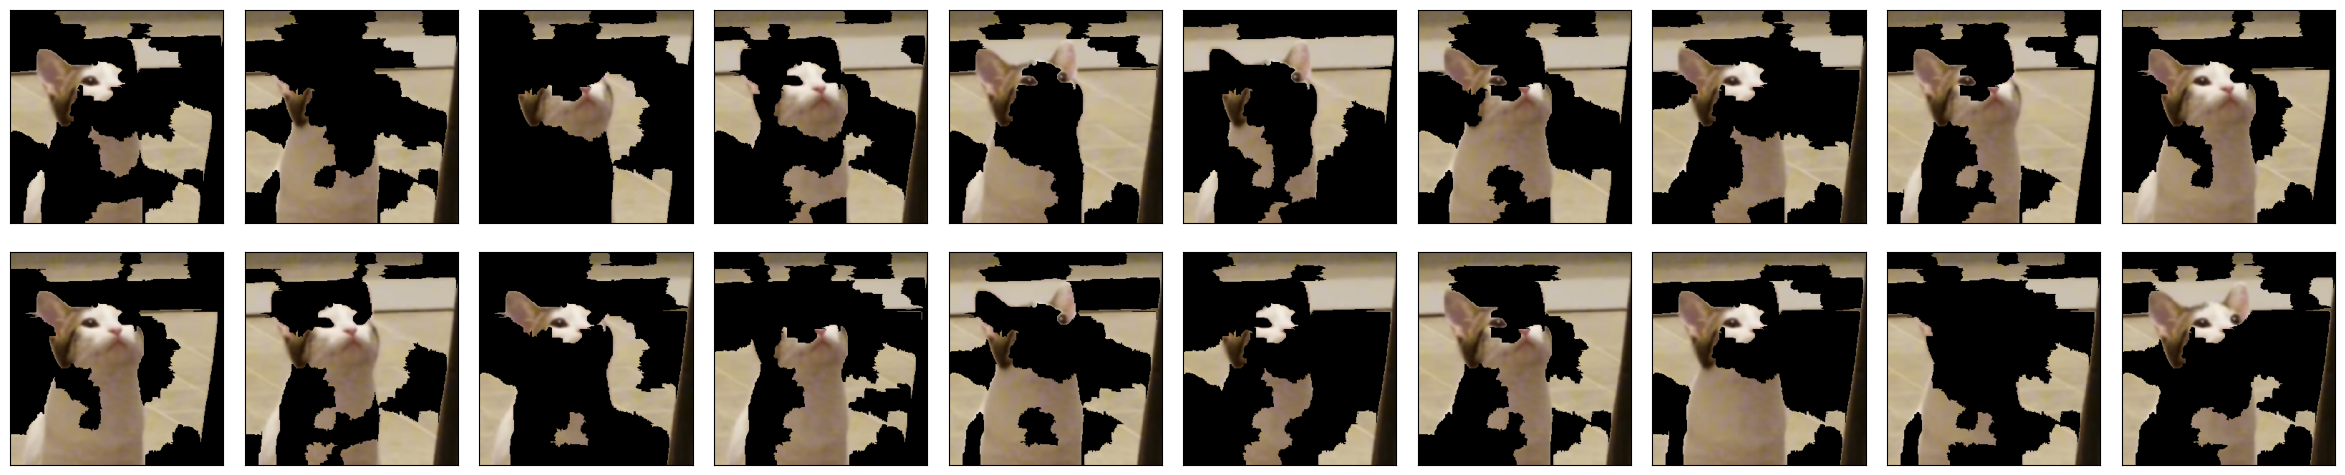

In [94]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(perturb_image(Xi[0]/2+0.5,perturbations[i],superpixels))
    ax[1, i].imshow(perturb_image(Xi[0]/2+0.5,perturbations[i+9],superpixels))

In [95]:
predictions = []
for pert in tqdm(perturbations):
    perturbed_img = perturb_image(Xi[0],pert,superpixels)
    pred = model.predict(np.expand_dims(perturbed_img, axis=0))
    predictions.append(pred)

predictions = np.array(predictions)

  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 2/150 [00:00<00:08, 18.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 4/150 [00:00<00:07, 18.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 6/150 [00:00<00:07, 18.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▌         | 8/150 [00:00<00:08, 17.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 10/150 [00:00<00:08, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 12/150 [00:00<00:07, 17.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 14/150 [00:00<00:07, 17.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 16/150 [00:00<00:07, 17.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 18/150 [00:01<00:07, 17.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 20/150 [00:01<00:07, 17.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 22/150 [00:01<00:06, 18.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 24/150 [00:01<00:06, 18.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 26/150 [00:01<00:06, 18.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▊        | 28/150 [00:01<00:06, 19.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 30/150 [00:01<00:06, 19.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██▏       | 32/150 [00:01<00:06, 19.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 34/150 [00:01<00:06, 18.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 36/150 [00:01<00:06, 18.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 38/150 [00:02<00:05, 19.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 40/150 [00:02<00:05, 19.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 42/150 [00:02<00:05, 19.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 44/150 [00:02<00:05, 19.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 46/150 [00:02<00:05, 19.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 48/150 [00:02<00:05, 19.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 50/150 [00:02<00:05, 19.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 52/150 [00:02<00:05, 19.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 55/150 [00:02<00:04, 19.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 57/150 [00:03<00:04, 19.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 59/150 [00:03<00:04, 19.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 61/150 [00:03<00:04, 19.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 63/150 [00:03<00:04, 19.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 65/150 [00:03<00:04, 19.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 67/150 [00:03<00:04, 19.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 69/150 [00:03<00:04, 19.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 71/150 [00:03<00:04, 19.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▊     | 73/150 [00:03<00:03, 19.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 75/150 [00:03<00:03, 19.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████▏    | 77/150 [00:04<00:03, 19.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 79/150 [00:04<00:03, 19.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 81/150 [00:04<00:03, 19.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 84/150 [00:04<00:03, 19.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 86/150 [00:04<00:03, 19.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 88/150 [00:04<00:03, 19.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 90/150 [00:04<00:03, 19.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████▏   | 92/150 [00:04<00:02, 19.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 94/150 [00:04<00:02, 19.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 96/150 [00:05<00:02, 18.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 98/150 [00:05<00:02, 18.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 100/150 [00:05<00:02, 18.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 102/150 [00:05<00:02, 19.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 104/150 [00:05<00:02, 19.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 106/150 [00:05<00:02, 19.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 108/150 [00:05<00:02, 19.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 110/150 [00:05<00:02, 18.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 112/150 [00:05<00:02, 19.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 114/150 [00:05<00:01, 19.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 116/150 [00:06<00:01, 19.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▊  | 118/150 [00:06<00:01, 19.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 120/150 [00:06<00:01, 19.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 122/150 [00:06<00:01, 18.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 124/150 [00:06<00:01, 18.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 126/150 [00:06<00:01, 18.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 128/150 [00:06<00:01, 18.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 130/150 [00:06<00:01, 18.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 132/150 [00:06<00:00, 18.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 134/150 [00:07<00:00, 18.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 136/150 [00:07<00:00, 18.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 138/150 [00:07<00:00, 18.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 140/150 [00:07<00:00, 18.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 142/150 [00:07<00:00, 18.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 144/150 [00:07<00:00, 18.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 146/150 [00:07<00:00, 18.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▊| 148/150 [00:07<00:00, 18.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|██████████| 150/150 [00:07<00:00, 18.91it/s]


In [96]:
X = pd.DataFrame(data=perturbations, columns=['SP'+str(i+1) for i in range(44)])
class_to_explain = top_pred_classes[0]
y = pd.DataFrame(data=predictions[:, :, class_to_explain], columns=['label'])
data = pd.concat([X, y], axis = 1)
data

,SP1,SP2,SP3,SP4,SP5,SP6,SP7,SP8,SP9,SP10,SP11,SP12,SP13,SP14,SP15,SP16,SP17,SP18,SP19,SP20,SP21,SP22,SP23,SP24,SP25,SP26,SP27,SP28,SP29,SP30,SP31,SP32,SP33,SP34,SP35,SP36,SP37,SP38,SP39,SP40,SP41,SP42,SP43,SP44,label
0,1,1,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,1,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0.000830
1,0,0,1,1,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,0,1,0,0,1,1,1,1,1,0.009331
2,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0.000724
3,1,1,0,1,1,1,1,1,1,1,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,0.001679
4,0,0,0,1,1,1,0,1,1,0,0,1,1,1,0,1,0,1,0,1,1,1,1,1,0,1,1,0,1,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,0.000326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,0,0,1,1,1,1,0,1,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,1,0,0.021980
146,1,1,0,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,1,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,1,0,0,1,0,1,1,0,0.003144
147,0,1,0,0,0,1,1,0,1,1,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0.001273
148,1,1,0,1,1,0,1,1,0,1,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,0.009475


In [97]:
from sklearn.linear_model import LinearRegression
simpler_model = LinearRegression()
simpler_model.fit(X, y)
print(simpler_model.coef_.shape)
coeff = simpler_model.coef_[0]
print(coeff.shape)
coeff

(1, 44)
(44,)


array([ 1.74664794e-04, -3.78646377e-04,  1.33551455e-03,  1.42115898e-03,
        6.51614280e-04, -1.27160781e-03,  2.02424525e-03, -5.00984912e-05,
       -5.60326515e-04,  2.07295072e-03,  5.88749597e-04, -6.56812084e-05,
        6.81981107e-04, -1.73687294e-03,  1.69305551e-03,  1.69948872e-04,
       -2.95455741e-04,  2.09826538e-03,  2.37100835e-03, -3.06612691e-04,
        1.55204636e-03, -4.67158015e-04,  2.45380035e-03,  7.21663018e-04,
        1.41559807e-03, -1.90376440e-04, -3.47526270e-04,  2.41175392e-03,
        2.23683813e-03,  5.23423559e-04, -4.04700555e-04, -1.19418747e-04,
       -7.43705173e-04,  5.27513772e-04, -1.29411456e-03, -1.16317827e-03,
       -5.67968778e-04, -6.16971338e-04, -2.30873655e-05, -1.82740269e-03,
       -2.76253188e-04, -1.58536653e-03, -7.25048243e-04,  1.41452905e-03])

In [98]:
num_top_features = 10
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([ 3, 20, 14,  6,  9, 17, 28, 18, 27, 22])

/var/folders/_2/gtg7fw9x1_n2k3c4s64fzkx80000gn/T/ipykernel_52970/335369855.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(perturb_image(Xi[0]/2+0.5, mask, superpixels))


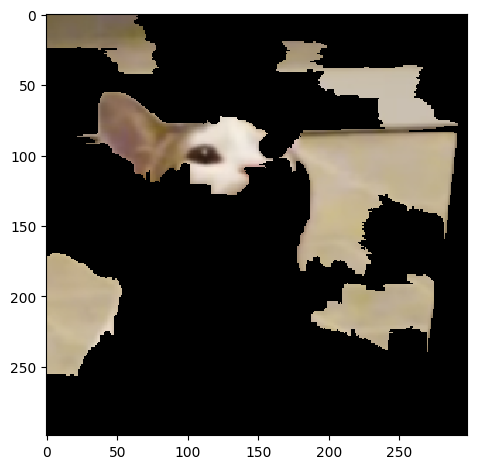

In [99]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi[0]/2+0.5, mask, superpixels))

In [100]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [101]:
def segment_fn(image):
    return skimage.segmentation.quickshift(image, kernel_size=5, max_dist=100, ratio=0.2)

explanation = explainer.explain_instance(Xi[0].astype('double'), model.predict, top_labels=5, num_samples=150,
                                         segmentation_fn = segment_fn)

  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


  7%|▋         | 10/150 [00:00<00:11, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 13%|█▎        | 20/150 [00:01<00:06, 20.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 20%|██        | 30/150 [00:01<00:04, 27.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 27%|██▋       | 40/150 [00:01<00:03, 31.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 33%|███▎      | 50/150 [00:01<00:02, 34.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 40%|████      | 60/150 [00:01<00:02, 37.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 47%|████▋     | 70/150 [00:02<00:02, 39.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 53%|█████▎    | 80/150 [00:02<00:01, 41.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 60%|██████    | 90/150 [00:02<00:01, 41.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 67%|██████▋   | 100/150 [00:02<00:01, 42.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 73%|███████▎  | 110/150 [00:03<00:00, 42.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 80%|████████  | 120/150 [00:03<00:00, 42.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 87%|████████▋ | 130/150 [00:03<00:00, 41.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 93%|█████████▎| 140/150 [00:03<00:00, 41.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


100%|██████████| 150/150 [00:04<00:00, 36.68it/s]


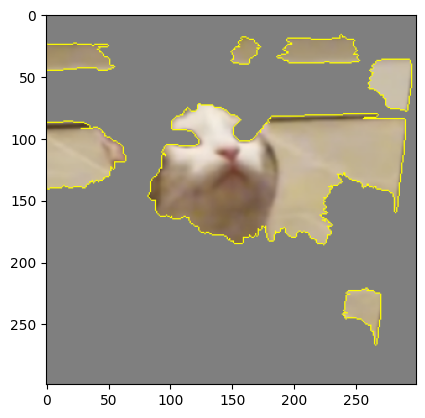

In [102]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [103]:
from interpret import show
# from interpret.blackbox import LimeTabular
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from e0_data import Cervical_DataLoader, Bike_DataLoader

In [104]:
from interpret.provider import InlineProvider
from interpret import set_visualize_provider

set_visualize_provider(InlineProvider())

In [105]:
## Classification Problem
data_loader = Cervical_DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()

X_train, X_test, y_train, y_test = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)

(686, 17)
(172, 17)


In [106]:
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

After oversampling: (1286, 17)


In [107]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
rfc = RandomForestClassifier(random_state=2022)
rfc.fit(X_train.values, y_train.values)
print("Training finished.")

y_pred = rfc.predict(X_test.values)
print(f"F1 Score: {round(f1_score(y_test, y_pred, average='macro'), 2)}")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")

Training finished.
F1 Score: 0.56
Accuracy: 0.94


In [109]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=[str(c) for c in y_train.unique()],
    mode='classification',
    random_state=2022
)


In [110]:
for i in range(10):
    exp = explainer.explain_instance(
        data_row=X_test.iloc[i].values,
        predict_fn=rfc.predict_proba,
        num_features=10
    )
    
    print(f"\nExplanation for test instance {i}:")
    # 使用 as_list() 顯示文字列表，不依賴 IPython
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight:.3f}")


Explanation for test instance 0:
Hormonal.Contraceptives..years. > 3.00: 0.098
Hormonal.Contraceptives_0 <= 0.00: -0.070
STDs_1 <= 0.00: -0.058
Number.of.sexual.partners <= 2.00: -0.056
STDs..number. <= 0.00: -0.045
STDs..Number.of.diagnosis <= 0.00: -0.037
15.08 < First.sexual.intercourse <= 17.00: 0.030
1.00 < Num.of.pregnancies <= 2.00: 0.025
26.12 < Age <= 34.00: 0.023
IUD..years. <= 0.00: -0.014

Explanation for test instance 1:
Hormonal.Contraceptives..years. <= 0.00: -0.245
Hormonal.Contraceptives_0 <= 0.00: -0.075
Age <= 21.00: -0.067
Number.of.sexual.partners <= 2.00: -0.062
STDs_1 <= 0.00: -0.061
STDs..number. <= 0.00: -0.045
Num.of.pregnancies <= 1.00: -0.037
STDs..Number.of.diagnosis <= 0.00: -0.028
First.sexual.intercourse <= 15.08: -0.020
IUD..years. <= 0.00: -0.015

Explanation for test instance 2:
Hormonal.Contraceptives..years. <= 0.00: -0.247
Hormonal.Contraceptives_0 <= 0.00: -0.079
STDs_1 <= 0.00: -0.063
Number.of.sexual.partners <= 2.00: -0.057
STDs..number. <= 0.